# Example of Randomization Via Stub-Matching



In [63]:
import numpy as np
import json

from math import pi

from ahyper import utils, annotated_hypergraph
from matplotlib import pyplot as plt
from scipy.special import binom

In [6]:
with open('data/enron_hypergraph_annotated.json') as file:
    data = json.load(file)

roles = ['cc', 'from', 'to']

A = annotated_hypergraph.AnnotatedHypergraph(data, roles)

In [7]:
A.remove_degeneracies(precedence={'from' : 1, 'to' : 2, 'cc' : 3})

Removed 1246 node-edge incidences


In [8]:
a = A.stub_matching()

In [9]:
a.count_degeneracies()

473

In [10]:
test1 = a.edge_dimensions(by_role = True) == A.edge_dimensions(by_role = True)
test2 = a.node_degrees(by_role = True)    == A.node_degrees(by_role = True)
test1, test2

(True, True)

# Stub Matching Experiment

While we could try to derive analytic estimates or Poisson limit laws for the degeneracy created by stub-matching, an alternative is just to simulate: 

In [22]:
n_reps = 1000

def experiment():
    a = A.stub_matching()
    return(a.count_degeneracies())

v = np.array([experiment() for i in range(n_reps)])

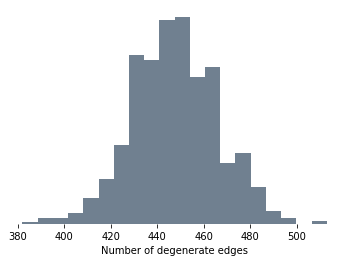

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(v, bins = 20, color = 'slategrey')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_visible(False)
ax.set_xlabel('Number of degenerate edges')
plt.savefig('fig/stub_matching_degeneracy.png', dpi = 300)

In [28]:
mu = v.mean()
sigma = np.sqrt(np.var(v))
mu, sigma

(447.653, 18.43416911607355)

What's the probability of stub-matching producing a nondegenerate graph? If we assume that the number of degeneracies is roughly Gaussian, we find that the probability is below machine precision: 

In [29]:
1 / (np.sqrt(2*pi*sigma)) * np.exp(-(mu)**2/(sigma**2))

7.275275677756522e-258

In [30]:
LP = - np.log(np.sqrt(2*pi)*sigma) - (mu**2/sigma**2)

In [31]:
LP

-593.5395752661085

# Let's try to estimate some lower bounds?

In [182]:
D = A.node_degrees(by_role=True)
d = np.array([D[key]['cc'] for key in D])

k = 4

In [204]:
def log_binom(n, k):
    n_fact = np.sum([np.log(a) for a in range(1, n + 1)])
    k_fact = np.sum([np.log(a) for a in range(1, k + 1)])
    nk_fact = np.sum([np.log(a) for a in range(1, n - k + 1)])
    return(n_fact - k_fact - nk_fact)
    

def log_sig(d, k, n_samples):
    def one_sample(d, k):
        return np.prod(np.random.choice(d, k, replace = False))
    
    v = np.array([one_sample(d, k) for i in range(n_samples)])
    
    log_num_terms = log_binom(len(d), k)
    
    return(np.log(v.mean()) + log_num_terms)

def estimate_degeneracy(d, k, n_samples):
    v = log_sig(d, k, n_samples)
    exponent = np.log(np.math.factorial(k)) + v - k * (np.log(d.mean()) + np.log(len(d)))
    return(np.exp(exponent))

In [205]:
k = 6
estimate_degeneracy(d, k, 100000) 
# so what this suggests is that an edge with $k$ from the given field is going to have this probability of being nondegenerate

0.5915033499834529

In [308]:
n_samples = 10**4

roles = ['cc', 'from', 'to']

K  = A.edge_dimensions(by_role = True)

role = 'to'

counts, dist = np.unique([L[v][role] for v in L], return_counts=True)

D = A.node_degrees(by_role = True)
d = np.array([D[key][role] for key in D])

degens = np.array([1 - estimate_degeneracy(d, k, n_samples) for k in counts])

degens[np.isnan(degens)] = 0

# LL = [roles(v) for v in L]

In [309]:
(degens*dist).sum()

16.499862970036823

In [310]:
degens

array([ 0.        , -0.01906469,  0.02220895,  0.14388729,  0.07155637,
        0.13499577,  0.2539859 ,  0.00518055,  0.77330008,  0.95094851,
        0.99843858,  0.99998409,  0.99999985,  1.        ,  1.        ,
        1.        ,  1.        ])